# **CONFIGURAÇÕES INICIAIS**

In [ ]:
# @title **Importando Bibliotecas**

# Para manipulação e análise de dados em tabelas (dataframes)
import pandas as pd

# Para cálculos númericos rápidos e eficientes com vetores e matrizes
import numpy as np

# Para criar gráficos e visualizações estáticas
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn2_unweighted, venn3_unweighted

# Para visualização de dados estatísticas com gráficos mais bonitos e informativos
import seaborn as sns

# Para análises de probabilidade
from scipy.stats import binom, poisson, norm, zscore

# Para baixar o CSV via link do Drive
import gdown

# Para suprimir apenas esse aviso específico de depreciação
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="venn2_unweighted is deprecated.*")
warnings.filterwarnings("ignore", category=UserWarning, message="venn3_unweighted is deprecated.*")

In [ ]:
#@title **Importando o CSV via Link do Drive**
# ID do arquivo no Google Drive
file_id = '19YSu2-PNFRcwnr8l2Rf8ReyrCWI2egC-'

# Montar a URL de download direto
url = f'https://drive.google.com/uc?id={file_id}'

# Nome do arquivo a ser salvo localmente
output = 'Mortalidade_Geral_2021.csv'

# Fazer o download
gdown.download(url, output, quiet=False)

# Carregar o CSV
df = pd.read_csv(output, sep=';')

# Impedir importação manual
executar_celula = False

Downloading...
From (original): https://drive.google.com/uc?id=19YSu2-PNFRcwnr8l2Rf8ReyrCWI2egC-
From (redirected): https://drive.google.com/uc?id=19YSu2-PNFRcwnr8l2Rf8ReyrCWI2egC-&confirm=t&uuid=3575c4c3-0d73-4951-85bb-0b7e6982f5d8
To: /content/Mortalidade_Geral_2021.csv
100%|██████████| 633M/633M [00:07<00:00, 79.6MB/s]
/tmp/ipython-input-2-1389281211.py:15: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output, sep=';')


## **Execuções Opcionais**

In [ ]:
#@title **Carregando o CSV sem Importar Novamente**

# Caso já tenha o arquivo .csv no ambiente, use esta opção

# Nome do arquivo a ser salvo localmente
output = 'Mortalidade_Geral_2021.csv'

# Carregar o CSV
df = pd.read_csv(output, sep=';')

### **Importando o CSV Manualmente (caso o método anterior não funcione)**

Caso o método anterior não funcione, realize o upload manual do CSV:

*   Baixe o arquivo do dataset [aqui](https://opendatasus.saude.gov.br/dataset/sim/resource/2dee2fc9-d19f-41bc-b058-6d4154f126ab).
*   Crie uma pasta "Colab Notebooks" no Drive e faça o upload do CSV nela.

In [ ]:
#@title { vertical-output: true, form-width: "40%" }
from google.colab import drive

if not executar_celula:
  print("Esta célula não foi executada pois a célula anterior já baixou o CSV.")
else:
  drive.mount('/content/drive/', force_remount=True)
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mortalidade_Geral_2021.csv', sep=';')

## **Preparação dos Dados**


In [154]:
# Filtrando somente as colunas a serem analisadas
colunas_desejadas = [
    'DTOBITO',          # Data do óbito
    'IDADE',            # Idade em formato codificado
    'SEXO',             # 1 = masculino, 2 = feminino
    'LOCOCOR',          # Local de ocorrência do óbito
    'ASSISTMED',        # Assistência médica
    'CAUSABAS',         # Causa básica da morte (CID-10)
    'TPOBITOCOR',       # Tipo de local do óbito
    'CIRCOBITO',        # Tipo de morte violenta ou circunstâncias em que se deu a morte não natural
    'ACIDTRAB',         # Acidente do trabalho (Sim ou Não)
]

sim = df[colunas_desejadas]

# Filtrando registros em que idade ≥ 1
sim = sim[sim['IDADE'].astype(str).str.startswith('4')]

# Retirando uma amostra do dataset
sim = sim.sample(n=100000, random_state=42)

# Decodificando variáveis categóricas
sim['SEXO_DESC'] = sim['SEXO'].map({1: 'M', 2: 'F'})
sim['SEXO_DESC'] = sim['SEXO_DESC'].fillna('Ignorado')

sim['ASSISTMED_DESC'] = sim['ASSISTMED'].map({
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
})

sim['LOCOCOR_DESC'] = sim['LOCOCOR'].map({
    1: 'Hospital',
    2: 'Outro estabelecimento de saúde',
    3: 'Domicílio',
    4: 'Via pública',
    5: 'Outros',
    9: 'Ignorado'
})

sim['CIRCOBITO_DESC'] = sim['CIRCOBITO'].map({
    1: 'Acidente',
    2: 'Suicídio',
    3: 'Homicídio',
    4: 'Outros',
    9: 'Ignorado'
})

sim['ACIDTRAB_DESC'] = sim['ACIDTRAB'].map({
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
})

sim['TPOBITOCOR_DESC'] = sim['TPOBITOCOR'].map({
    1: 'Via pública',
    2: 'Residência',
    3: 'Outro domicílio',
    4: 'Estabelecimento comercial',
    5: 'Outros',
    9: 'Ignorada'
})

# Transformando a idade
def converter_idade(codigo):
    codigo = str(int(codigo)).zfill(3)
    valor = int(codigo[1:])
    return valor

sim['IDADE_ANOS'] = sim['IDADE'].apply(converter_idade)

# Convertendo data
sim['DTOBITO_DATA'] = pd.to_datetime(sim['DTOBITO'], format='%d%m%Y', errors='coerce')

sim.head()

,DTOBITO,IDADE,SEXO,LOCOCOR,ASSISTMED,CAUSABAS,TPOBITOCOR,CIRCOBITO,ACIDTRAB,SEXO_DESC,ASSISTMED_DESC,LOCOCOR_DESC,CIRCOBITO_DESC,ACIDTRAB_DESC,TPOBITOCOR_DESC,IDADE_ANOS,DTOBITO_DATA
225649,5092021,466,1,1,1.0,R99,NaN,NaN,NaN,M,Sim,Hospital,NaN,NaN,NaN,66,2021-09-05
280731,20042021,443,2,3,2.0,X959,9.0,3.0,NaN,F,Não,Domicílio,Homicídio,NaN,Ignorada,43,2021-04-20
1515340,25042021,471,2,1,1.0,I509,NaN,NaN,NaN,F,Sim,Hospital,NaN,NaN,NaN,71,2021-04-25
1156536,24022021,473,1,1,NaN,D599,NaN,NaN,NaN,M,NaN,Hospital,NaN,NaN,NaN,73,2021-02-24
1181779,11022021,454,1,1,9.0,B342,NaN,NaN,NaN,M,Ignorado,Hospital,NaN,NaN,NaN,54,2021-02-11


---
# **SIM - ANÁLISES DE PROBABILIDADES**

In [155]:
# @title { vertical-output: true, form-width: "50%" }

# VALORES GERAIS DE INTERESSE

# Tamanho amostral
n_amostral = len(sim)
print(f'Tamanho da Amostra: {n_amostral}')

Tamanho da Amostra: 100000


---
## **1. Probabilidade Composta (Interseção)**

### **1.1 Qual a probabilidade de óbito ser de uma mulher e causado por neoplasia maligna?**

**Objetivo:** calcular 𝑃(𝐹 ∩ neoplasia)


#### **1.1.1 Calculando a probabilidade**

In [133]:
# Criando egex para os CIDs entre C00 e C97 (neoplasia maligna)
regex_neoplasia = r'^C(0[0-9]|[1-8][0-9]|9[0-7])[A-Z0-9]?$'

# Filtrando causas básicas que são neoplasias malignas
filtro_neoplasia = sim['CAUSABAS'].astype(str).str.match(regex_neoplasia)

# Filtrando mulheres
filtro_mulher = sim['SEXO_DESC'] == 'F'

# Combinando filtros: mulher e causa neoplasia
interseccao = sim[(filtro_neoplasia) & (filtro_mulher)]

# Calculando a probabilidade conjunta P(F ∩ neoplasia)
p_mulher_neoplasia = len(interseccao) / n_amostral

print(f"P(F ∩ Neoplasia) = {p_mulher_neoplasia:.4f} → {p_mulher_neoplasia:.2%}")

P(F ∩ Neoplasia) = 0.0612 → 6.12%


#### **1.1.2 Gerando diagrama de Venn**

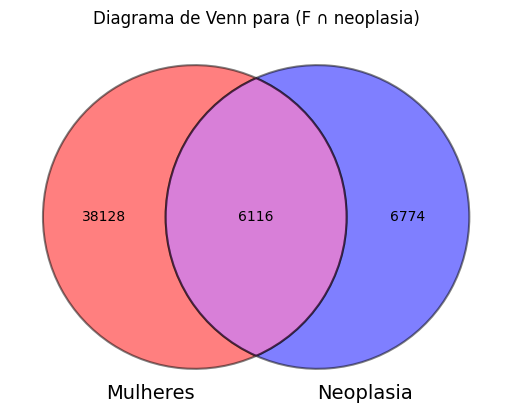

In [156]:
# @title { vertical-output: true, form-width: "39%" }

# Criando os conjuntos
set1 = set(sim[filtro_mulher].index)
set2 = set(sim[filtro_neoplasia].index)

v = venn2_unweighted([set1, set2], set_labels=('Mulheres', 'Neoplasia'), set_colors=('red', 'blue'))

# Ajustando transparência
for patch in v.patches:
    if patch:
        patch.set_alpha(0.5)
        patch.set_edgecolor("black")
        patch.set_linewidth(1.5)

# Ajustando tamanho dos labels dos conjuntos
for label in v.set_labels:
    if label:
        label.set_fontsize(14)

# Ajustando tamanho dos labels internos
for label_id in ['10', '01', '11']:
    label = v.get_label_by_id(label_id)
    if label:
        label.set_fontsize(10)

plt.title("Diagrama de Venn para (F ∩ neoplasia)")
plt.show()

### **1.2 Qual a probabilidade de uma mulher ter tido uma morte violenta do tipo homicídio? E para o homem?**

**Objetivo:** calcular 𝑃(F ∩ homicídio) e 𝑃(M ∩ homicídio)


#### **1.2.1 Calculando as probabilidades**

In [158]:
# Filtrando homicídios
filtro_homicidio = sim['CIRCOBITO_DESC'] == 'Homicídio'

# Filtrando mulheres
filtro_mulher = sim['SEXO_DESC'] == 'F'

# Filtrando homens
filtro_homem = sim['SEXO_DESC'] == 'M'

# Combinando filtros
interseccao_mulher_homicidio = sim[(filtro_homicidio) & (filtro_mulher)]
interseccao_homem_homicidio = sim[(filtro_homicidio) & (filtro_homem)]

# Calculando as probabilidades
p_mulher_homicidio = len(interseccao_mulher_homicidio) / n_amostral
p_homem_homicidio = len(interseccao_homem_homicidio) / n_amostral

# Exibindo as probabilidades
print(f"P(F ∩ Homicídio) = {p_mulher_homicidio:.4f} → {p_mulher_homicidio:.2%}")
print(f"P(M ∩ Homicídio) = {p_homem_homicidio:.4f} → {p_homem_homicidio:.2%}")

P(F ∩ Homicídio) = 0.0021 → 0.21%
P(M ∩ Homicídio) = 0.0216 → 2.16%


#### **1.2.2 Gerando diagrama de Venn**

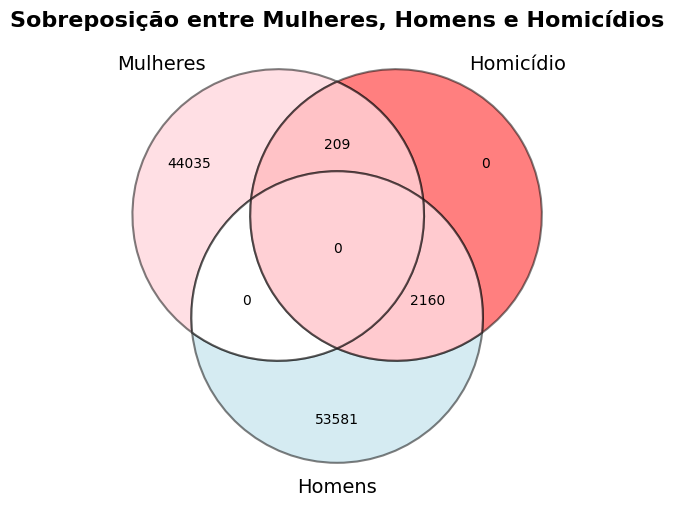

In [159]:
# @title { vertical-output: true, form-width: "40%" }

plt.figure(figsize=(8, 6))

# Criando os conjuntos
set1 = set(sim[filtro_mulher].index)
set2 = set(sim[filtro_homicidio].index)
set3 = set(sim[filtro_homem].index)

# Diagrama de Venn com círculos de mesmo tamanho
v = venn3_unweighted([set1, set2, set3],
                     set_labels=('Mulheres', 'Homicídio', 'Homens'),
                     set_colors=('pink', 'red', 'lightblue'))

# Ajustando transparência e bordas
for patch in v.patches:
    if patch:
        patch.set_alpha(0.5)
        patch.set_edgecolor("black")
        patch.set_linewidth(1.5)

# Ajustando tamanho dos labels dos conjuntos
for label in v.set_labels:
    if label:
        label.set_fontsize(14)

# Ajustando tamanho dos labels internos
for label_id in ['100', '010', '001', '110', '101', '011', '111']:
    label = v.get_label_by_id(label_id)
    if label:
        label.set_fontsize(10)

# Título
plt.title("Sobreposição entre Mulheres, Homens e Homicídios", fontsize=16, fontweight='bold')
plt.show()


### **1.3 Qual a probabilidade de um óbito ter sido acidente de trabalho ou ocorrido em estabelecimento comercial?**

**Objetivo:** calcular 𝑃(acidente de trabalho ∪ estabelecimento comercial)


#### **1.3.1 Calculando a probabilidade**

In [138]:
# Filtrando acidentes de trabalho
filtro_acidente = sim['ACIDTRAB_DESC'] == 'Sim'

# Filtrando local de óbito = estabelecimento comercial
filtro_estabelecimento = sim['TPOBITOCOR_DESC'] == 'Estabelecimento comercial'

# Combinando filtros: mulher e causa neoplasia
uniao = sim[(filtro_acidente) | (filtro_estabelecimento)]

# Calculando a probabilidade
p_uniao = len(uniao) / n_amostral

# Exibindo a probabilidade
print(f"P(Acidente de Trabalho ∪ Estabelecimento Comercial) = {p_uniao:.4f} → {p_uniao:.2%}")

P(Acidente de Trabalho ∪ Estabelecimento Comercial) = 0.0022 → 0.22%


#### **1.3.2 Gerando diagrama de Venn**

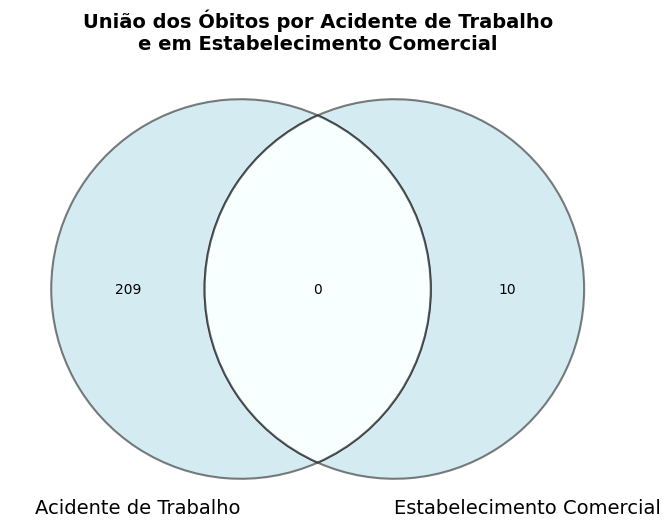

In [139]:
# @title { vertical-output: true, form-width: "45%" }

plt.figure(figsize=(8, 6))

# Criando os conjuntos
set1 = set(sim[filtro_acidente].index)
set2 = set(sim[filtro_estabelecimento].index)

# Diagrama de Venn com círculos de mesmo tamanho
v = venn2_unweighted([set1, set2],
                     set_labels=('Acidente de Trabalho', 'Estabelecimento Comercial'),
                     set_colors=('lightblue', 'lightblue'))

# Ajustando transparência e bordas
for patch in v.patches:
    if patch:
        patch.set_alpha(0.5)
        patch.set_edgecolor("black")
        patch.set_linewidth(1.5)

# Ajustando tamanho dos labels dos conjuntos
for label in v.set_labels:
    if label:
        label.set_fontsize(14)

# Ajustando tamanho dos labels internos
for label_id in ['10', '01', '11']:
    label = v.get_label_by_id(label_id)
    if label:
        label.set_fontsize(10)

# Título
plt.title("União dos Óbitos por Acidente de Trabalho\ne em Estabelecimento Comercial", fontsize=14, fontweight='bold')
plt.show()


---
## **2. Probabilidade Condicional**

### **2.1 Probabilidade de óbito por causas violentas dado que a pessoa era jovem (15–29 anos)**

**Objetivo:** calcular 𝑃 ( causa violenta ∣ idade 15–29 )

In [160]:
# Criando função auxiliar para filtrar somente os CIDs válidos para causa violenta
import re

def causa_violenta(cid):
    if isinstance(cid, str):
        match = re.match(r'^([A-Z])(\d{2})', cid)
        if match:
            letra = match.group(1)
            numero = int(match.group(2))
            if letra == 'V':
                return True
            if letra == 'W':
                return True
            if letra == 'X':
                return True
            if letra == 'Y' and 10 <= numero <= 36:
                return True
    return False

In [161]:
# Filtrando jovens entre 15 e 29 anos
filtro_jovens = sim['IDADE_ANOS'].between(15, 29)
p_jovens = filtro_jovens.mean()

# Filtrando causas básicas que são violentas
filtro_violenta = sim['CAUSABAS'].apply(causa_violenta)

# Combinando filtros: jovens e causa violenta
interseccao = sim[(filtro_jovens) & (filtro_violenta)]
p_interseccao = len(interseccao) / n_amostral

# Calculando a probabilidade condicional
p_violenta_dado_jovem = p_interseccao / p_jovens
print(f"P(Causa Violenta | Idade 15–29 anos) = {p_violenta_dado_jovem:.4f} → {p_violenta_dado_jovem:.2%}")

P(Causa Violenta | Idade 15–29 anos) = 0.5862 → 58.62%


### **2.2 Probabilidade de ser homem, dado que a morte foi por agressão**

**Objetivo:** calcular 𝑃 ( homem ∣ agressão )

In [163]:
# Filtrando agressões
filtro_agressoes = sim['CAUSABAS'].str.startswith(('X8', 'X9', 'Y0'))

# Calculando P(B) → P(Agressão)
p_agressoes = filtro_agressoes.mean()

# Filtrando homens
filtro_homens = sim['SEXO_DESC'] == 'M'

# Combinando filtros: agressões e homens
interseccao = sim[(filtro_agressoes) & (filtro_homens)]

# Calculando P(A ∩ B) → P(Homem ∩ Agressão)
p_interseccao = len(interseccao) / n_amostral

# Calculando a probabilidade condicional
p_homem_dado_agressao = p_interseccao / p_agressoes
print(f"P(Homem ∣ Agressão) = {p_homem_dado_agressao:.4f} → {p_homem_dado_agressao:.2%}")

P(Homem ∣ Agressão) = 0.9081 → 90.81%


### **2.3 Probabilidade de não ter assistência médica, dado que o óbito foi no domicílio**

**Objetivo:** calcular 𝑃 ( sem assistência média ∣ domicílio )

In [165]:
# Filtrando óbitos em domicílio
filtro_domicilio = sim['LOCOCOR_DESC'] == 'Domicílio'

# Calculando P(B) → P(Óbito em domicílio)
p_domicilio = filtro_domicilio.mean()

# Filtrando sem assistência médica
filtro_sem_assistencia = sim['ASSISTMED_DESC'] == 'Não'

# Combinando filtros: domicílio e sem assistência médica
interseccao = sim[(filtro_domicilio) & (filtro_sem_assistencia)]

# Calculando P(A ∩ B) → P(Sem assistência médica ∩ Óbito em domicílio)
p_interseccao = len(interseccao) / n_amostral

# Calculando a probabilidade condicional
p_sem_assist_dado_domicilio = p_interseccao / p_domicilio
print(f"P(Sem Assistência Médica ∣ Domicílio) = {p_sem_assist_dado_domicilio:.4f} → {p_sem_assist_dado_domicilio:.2%}")

P(Sem Assistência Médica ∣ Domicílio) = 0.2667 → 26.67%


---
## **3. Teorema de Bayes**

### **3.1 Probabilidade de um óbito ter ocorrido no domicílio dado que não houve assistência médica**

**Objetivo:** calcular 𝑃 (óbito no domicílio | sem assistência médica)

In [202]:
# Filtrando óbitos em domicílio
filtro_domicilio = sim['LOCOCOR_DESC'] == 'Domicílio'

# Calculando P(A) → P(Óbito no domicílio)
p_domicilio = filtro_domicilio.mean()

# Calculando P(B) → P(Sem assistência médica)
p_sem_assistencia = (sim['ASSISTMED_DESC'] == 'Não').mean()

# Probabilidade de não ter havido assistência médica dado que ocorreu em domicílio
p_sem_assist_dado_domicilio = (sim.loc[filtro_domicilio, 'ASSISTMED_DESC'] == 'Não').mean()

# Calculando P(A | B) → P(Óbito em domicílio | Sem assistência médica)
p_domicilio_dado_sem = (p_sem_assist_dado_domicilio * p_domicilio) / p_sem_assistencia
print(f"P(Domicílio | Sem assistência médica) = {p_domicilio_dado_sem:.2%}")

P(Domicílio | Sem assistência médica) = 55.66%


### **3.2 Probabilidade de um indivíduo ter morrido por agressão dado que era do sexo masculino**

**Objetivo:** calcular 𝑃 (agressão | homem)

In [205]:
# Filtrando agressão
filtro_agressao = sim['CAUSABAS'].str.startswith(('X8', 'X9', 'Y0'))

# Filtrando homens
filtro_homens = sim['SEXO_DESC'] == 'M'

# Calculando P(A) → P(Agressão)
p_agressao = filtro_agressao.mean()

# Calculando P(B) → P(Homem)
p_homem = filtro_homens.mean()

# Probabilidade de ter morrido por agressão dado que era homem
p_homem_dado_agressao = (sim.loc[filtro_agressao, 'SEXO_DESC'] == 'M').mean()

# Calculando P(A | B) → P(Agressão | Homem)
p_agressao_dado_homem = (p_homem_dado_agressao * p_agressao) / p_homem
print(f"P(Agressão | Homem) = {p_agressao_dado_homem:.2%}")

P(Agressão | Homem) = 4.17%


### **3.3 Probabilidade do óbito ter sido de um idoso (idade >= 60) dado que ocorreu no hospital**

**Objetivo:** calcular 𝑃 (idoso | hospital)

In [206]:
# Filtrando hospital
filtro_hospital = sim['LOCOCOR_DESC'] == 'Hospital'

# Filtrando idade
filtro_idade = sim['IDADE_ANOS'] >= 60

# Calculando P(A) → P(Idoso)
p_idoso = filtro_hospital.mean()

# Calculando P(B) → P(Hospital)
p_hospital = filtro_idade.mean()

# Probabilidade do óbito ter ocorrido em hospital dado que era idoso
p_hospital_dado_idoso = (sim.loc[filtro_idade, 'LOCOCOR_DESC'] == 'Hospital').mean()

# Calculando P(A | B) → P(Idoso | Hospital)
p_idoso_dado_hospital = (p_hospital_dado_idoso * p_idoso) / p_hospital
print(f"P(Idoso | Hospital) = {p_idoso_dado_hospital:.2%}")

P(Idoso | Hospital) = 70.07%


---
## **4. Distribuições Discretas**

### **4.1 Distribuição Binomial**

#### **4.1.1 Em uma amostra de 10 certidões aleatórias, qual a probabilidade de exatamente 4 terem causa “cardiovascular”?**

In [173]:
# Verificando se o código CAUSABAS começa com "I" (doenças do sistema circulatório)
filtro_cardiovascular = sim['CAUSABAS'].astype(str).str.startswith('I')

# Calculando a probabilidade de sucesso na amostra
p_cardiovascular = filtro_cardiovascular.mean()

print(f"P(Causa cardiovascular) na amostra = {p_cardiovascular:.4f} → {p_cardiovascular:.2%}")

# Parâmetros da distribuição binomial
n = 10
k = 4
p = p_cardiovascular  # estimado do dataset

# Distribuição Binomial
prob = binom.pmf(k, n, p)
print(f"P(X = 4) com p estimado = {prob:.4f} → {prob:.2%}")

P(Causa cardiovascular) na amostra = 0.2127 → 21.27%
P(X = 4) com p estimado = 0.1023 → 10.23%


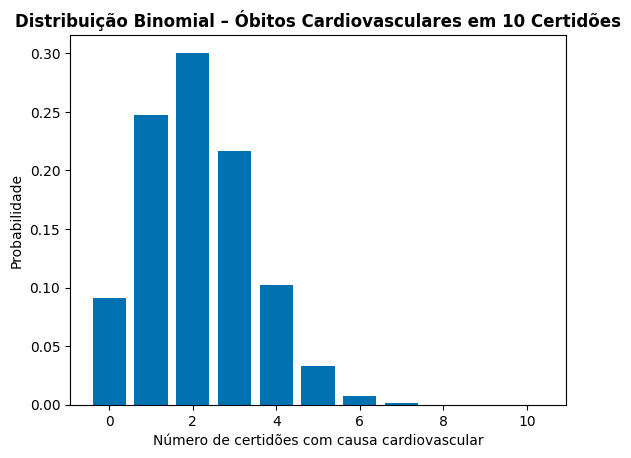

In [184]:
# @title { vertical-output: true, form-width: "50%" }

# Gerando o gráfico
x = range(0, 11)
y = binom.pmf(x, n=10, p=p_cardiovascular)

plt.bar(x, y)
plt.title('Distribuição Binomial – Óbitos Cardiovasculares em 10 Certidões', weight='bold')
plt.xlabel('Número de certidões com causa cardiovascular')
plt.ylabel('Probabilidade')
plt.show()

#### **4.1.2 Entre 300 mortes por doenças cardíacas, qual a chance de menos de 150 serem homens?**

In [179]:
# Verificando se o código CAUSABAS começa com "I" (doenças do sistema circulatório)
filtro_cardiacas = sim['CAUSABAS'].str.startswith('I')
dados_cardio = sim[filtro_cardiacas]

# Calculando a probabilidade de sucesso na amostra
p_homens = (dados_cardio['SEXO_DESC'] == 'M').mean()

# Parâmetros
n = 300
k = 150
p = p_homens  # probabilidade de um óbito ser de homem

# Distribuição Binomial
prob = binom.pmf(k, n, p)
print(f"P(X = 4) com p estimado = {prob:.4f} → {prob:.2%}")

P(X = 4) com p estimado = 0.0364 → 3.64%


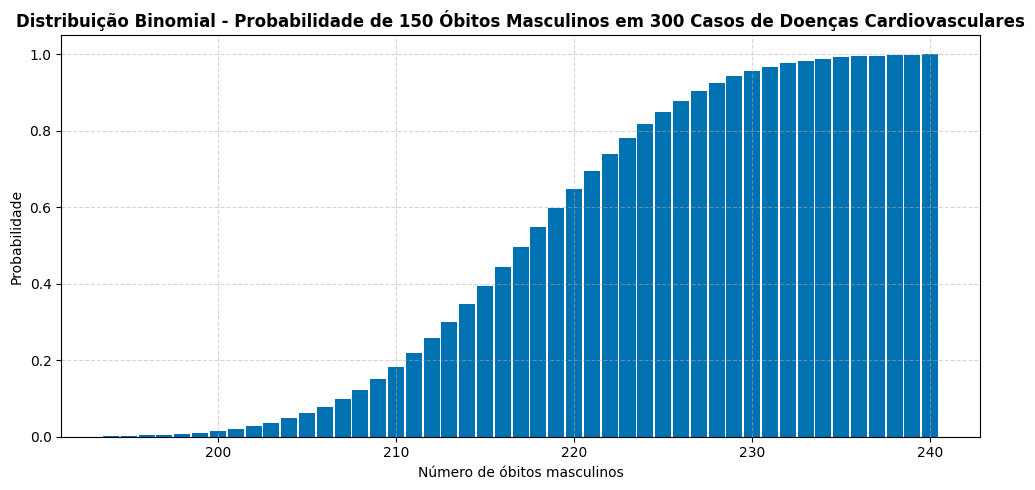

In [197]:
# @title { vertical-output: true, form-width: "60%" }

# Média e desvio padrão
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# Intervalo mais provável
x = range(int(mu - 3*sigma), int(mu + 3*sigma) + 1)
y = binom.cdf(x, n, p)

# Gráfico
plt.figure(figsize=(10, 5))
plt.bar(x, y, width=0.9)

# Títulos e legendas
plt.title('Distribuição Binomial - Probabilidade de 150 Óbitos Masculinos em 300 Casos de Doenças Cardiovasculares', weight='bold')
plt.xlabel('Número de óbitos masculinos')
plt.ylabel('Probabilidade')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### **4.2 Distribuição de Poisson**

#### **4.2.1 Probabilidade de haver no máximo 75 mortes por COVID em um dia considerando a média diária**

Média diária (λ) = 70.59
P(X = 75 mortes) = 0.7250 → 72.50%



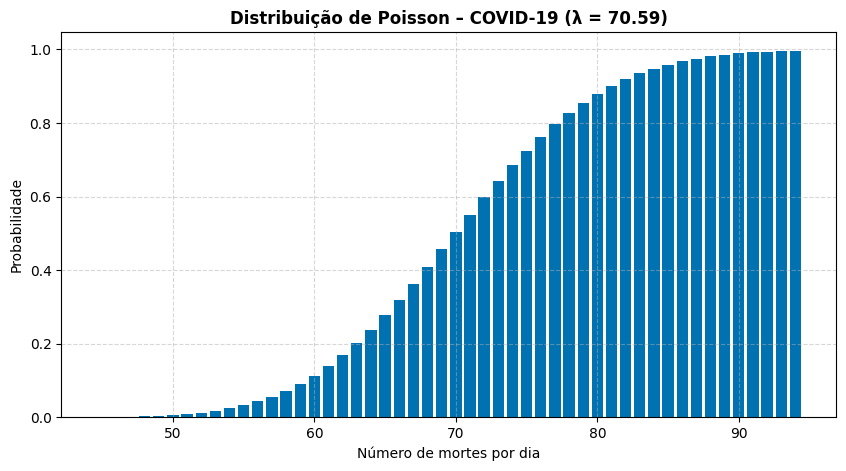

In [193]:
# @title { vertical-output: true, form-width: "51%" }

# Filtrando para COVID
filtro_covid = sim['CAUSABAS'].isin(['B342'])

# Agrupando por data
mortes_por_dia = sim[filtro_covid].groupby(sim['DTOBITO_DATA'].dt.date).size()

# λ = média diária
lambda_covid = mortes_por_dia.mean()
print(f"Média diária (λ) = {lambda_covid:.2f}")

k = 75  # por exemplo
p = poisson.cdf(k, mu=lambda_covid)
print(f"P(X = {k} mortes) = {p:.4f} → {p:.2%}\n")

# Distribuição de Poisson
k_vals = range(int(lambda_covid - 3 * lambda_covid**0.5), int(lambda_covid + 3 * lambda_covid**0.5))
probs = poisson.cdf(k_vals, mu=lambda_covid)

# Gráfico
plt.figure(figsize=(10, 5))
plt.bar(k_vals, probs)
plt.title(f'Distribuição de Poisson – COVID-19 (λ = {lambda_covid:.2f})', weight='bold')
plt.xlabel('Número de mortes por dia')
plt.ylabel('Probabilidade')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### **4.2.2 Probabilidade de haver mais de 180 mortes por acidente de trânsito em um mês**

In [200]:
# Filtrando para acidentes de trânsito
filtro_transito = sim['CAUSABAS'].str.startswith(tuple([f"V{str(i).zfill(2)}" for i in range(1, 90)]))
mortes_transito = sim[filtro_transito]

# Lambda mensal
lambda_mensal = mortes_transito.shape[0] / 12

# Prob. de mais de 180
prob_180 = 1 - poisson.cdf(180, mu=lambda_mensal)

print(f"Média mensal de mortes por trânsito: {lambda_mensal:.2f}")
print(f"Probabilidade de mais de 200: {prob_180:.4f} → {prob_180:.2%}")

Média mensal de mortes por trânsito: 159.00
Probabilidade de mais de 200: 0.0463 → 4.63%


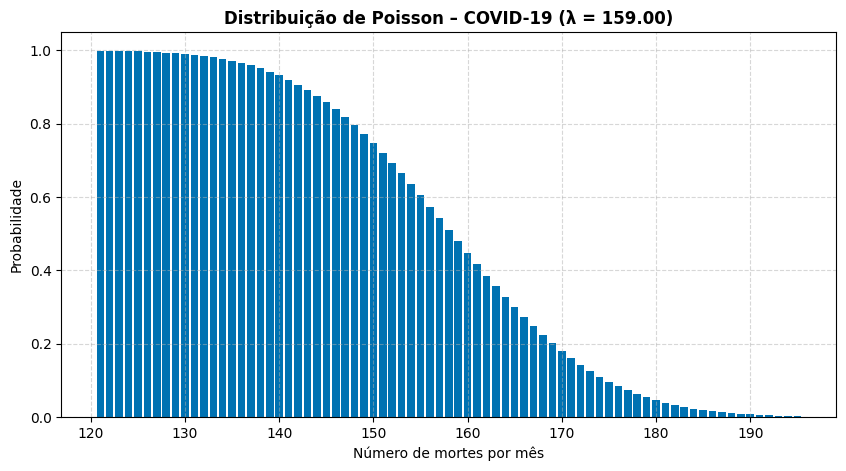

In [201]:
# @title { vertical-output: true, form-width: "50%" }

# Distribuição de Poisson
k_vals = range(int(lambda_mensal - 3 * lambda_mensal**0.5), int(lambda_mensal + 3 * lambda_mensal**0.5))
probs = 1 - poisson.cdf(k_vals, mu=lambda_mensal)

# Gráfico
plt.figure(figsize=(10, 5))
plt.bar(k_vals, probs)
plt.title(f'Distribuição de Poisson – COVID-19 (λ = {lambda_mensal:.2f})', weight='bold')
plt.xlabel('Número de mortes por mês')
plt.ylabel('Probabilidade')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()